In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_score

print("Библиотеки загружены")

Библиотеки загружены


In [2]:
# Загрузка подготовленного датасета
train_df = pd.read_csv('../data/train.csv')
print("Данные загружены")
print(f"Размер: {train_df.shape}")
print(f"Колонки: {list(train_df.columns)}")

# Предобработка данных как в lab1
def preprocess_data(df):
    """Предобработка данных как в первой лабораторной"""
    df_processed = df.copy()
    
    # Заполнение пропусков
    for col in df_processed.columns:
        if df_processed[col].isnull().sum() > 0:
            if df_processed[col].dtype == 'object':
                mode_val = df_processed[col].mode()[0]
                df_processed[col].fillna(mode_val, inplace=True)
            else:
                median_val = df_processed[col].median()
                df_processed[col].fillna(median_val, inplace=True)
    
    # One-Hot Encoding для категориальных признаков
    categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
    categorical_cols = [col for col in categorical_cols if col in df_processed.columns]
    
    if categorical_cols:
        df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    return df_processed

# Применяем предобработку
train_processed = preprocess_data(train_df)
print("Данные предобработаны")
print(f"Новый размер: {train_processed.shape}")

# Создаем целевую переменную для классификации
# будем предсказывать CryoSleep
if 'CryoSleep_True' in train_processed.columns:
    target = 'CryoSleep_True'
    print("Используем CryoSleep как целевую переменную")
else:
    # Создаем искусственную целевую переменную
    train_processed['Target'] = (train_processed['Age'] > 30).astype(int)
    target = 'Target'
    print("Создана целевая переменная: Age > 30")

# Разделяем на features и target
X = train_processed.drop(target, axis=1)
y = train_processed[target]

# Убираем нечисловые колонки
X = X.select_dtypes(include=[np.number])

print(f"Features: {X.shape}, Target: {y.shape}")
print(f"Распределение классов: {y.value_counts()}")

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Данные подготовлены для обучения")

Данные загружены
Размер: (8693, 14)
Колонки: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']
Данные предобработаны
Новый размер: (8693, 16)
Используем CryoSleep как целевую переменную
Features: (8693, 11), Target: (8693,)
Распределение классов: 0    5656
1    3037
Name: CryoSleep_True, dtype: int64
Данные подготовлены для обучения


In [3]:
# Случайный лес с OOB оценкой

# Создаем модель случайного леса с OOB
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    oob_score=True,  # Включаем OOB оценку
    n_jobs=-1
)

# Обучение модели
rf_model.fit(X_train_scaled, y_train)

# OOB оценка
oob_score = rf_model.oob_score_
print(f"OOB Score: {oob_score:.4f}")

# Предсказания
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Оценка качества
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

OOB Score: 0.9445
Accuracy: 0.9436

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1131
           1       0.90      0.94      0.92       608

    accuracy                           0.94      1739
   macro avg       0.93      0.94      0.94      1739
weighted avg       0.94      0.94      0.94      1739



In [4]:
# AdaBoost и Градиентный бустинг

# AdaBoost
adaboost_model = AdaBoostClassifier(
    n_estimators=50,
    random_state=42
)

adaboost_model.fit(X_train_scaled, y_train)
y_pred_ada = adaboost_model.predict(X_test_scaled)
y_pred_proba_ada = adaboost_model.predict_proba(X_test_scaled)[:, 1]

accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f"AdaBoost Accuracy: {accuracy_ada:.4f}")

# Градиентный бустинг
gradient_boost_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gradient_boost_model.fit(X_train_scaled, y_train)
y_pred_gb = gradient_boost_model.predict(X_test_scaled)
y_pred_proba_gb = gradient_boost_model.predict_proba(X_test_scaled)[:, 1]

accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb:.4f}")

AdaBoost Accuracy: 0.9413
Gradient Boosting Accuracy: 0.9436


СРАВНЕНИЕ МОДЕЛЕЙ:
Random Forest Accuracy: 0.9436
AdaBoost Accuracy: 0.9413
Gradient Boosting Accuracy: 0.9436
Random Forest OOB Score: 0.9445


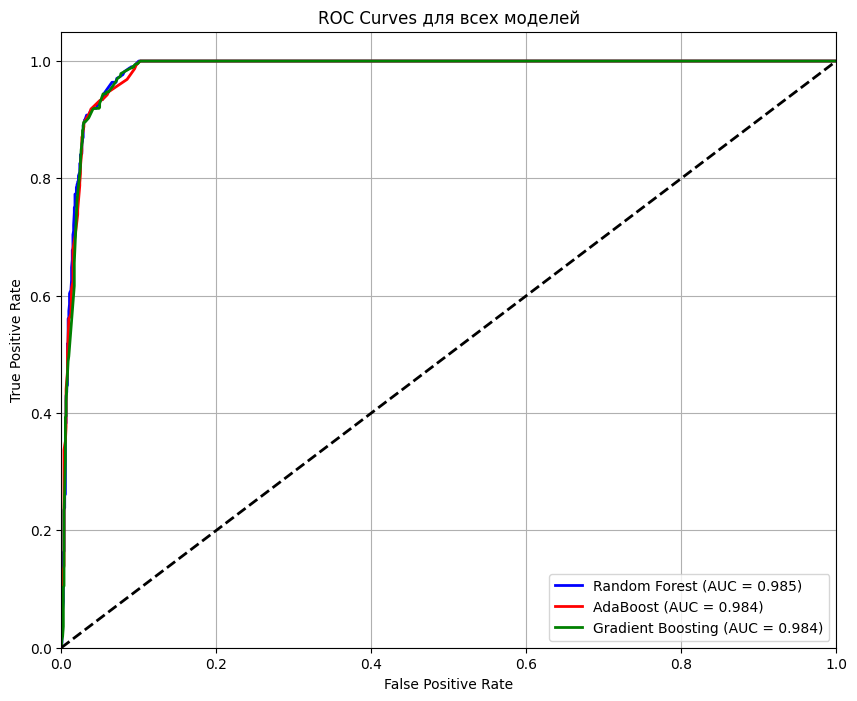

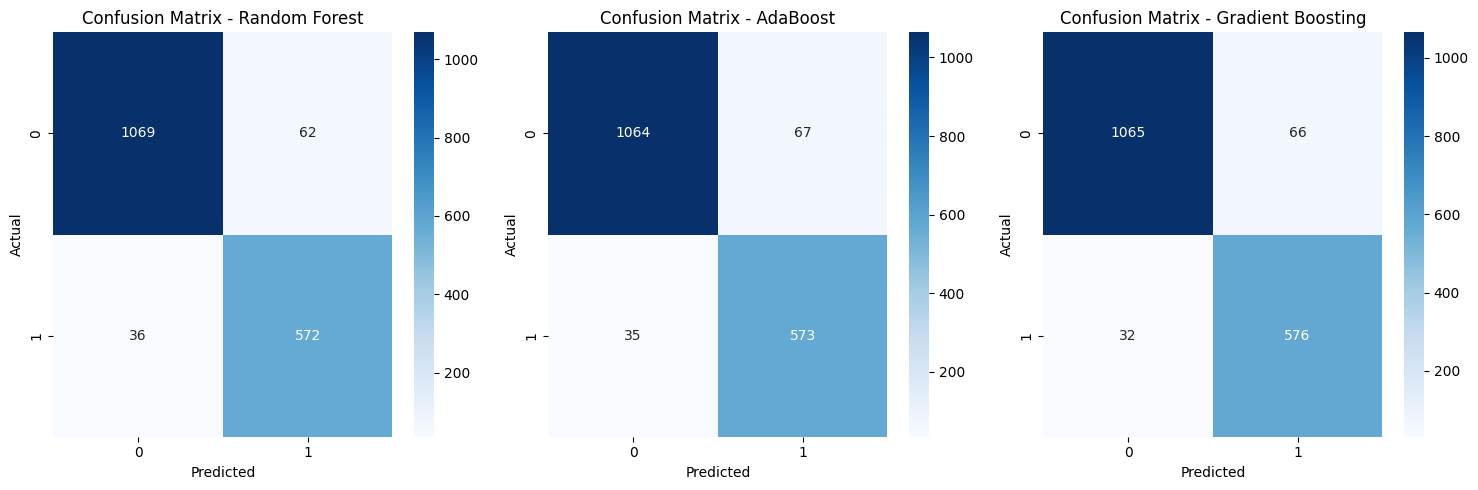

КРОСС-ВАЛИДАЦИЯ (5-fold):
Random Forest: 0.9428 (±0.0058)
AdaBoost: 0.9386 (±0.0031)
Gradient Boosting: 0.9429 (±0.0043)


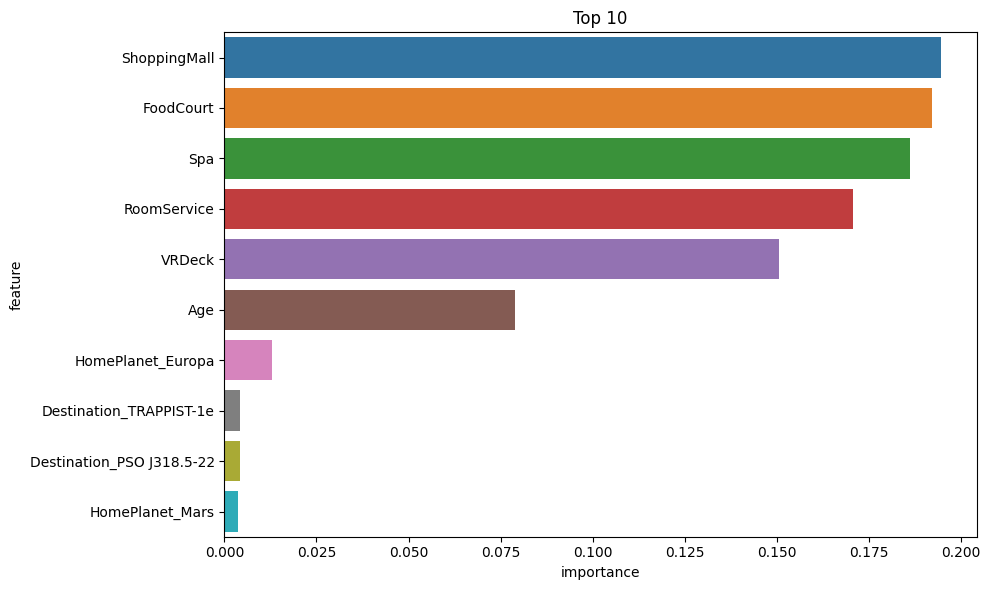

ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:
               Model  Accuracy     AUC  OOB_Score
0      Random Forest    0.9436  0.9850     0.9445
1           AdaBoost    0.9413  0.9842        NaN
2  Gradient Boosting    0.9436  0.9838        NaN


In [6]:
# Оценка моделей и ROC-кривые

# Сравнение accuracy всех моделей
print("СРАВНЕНИЕ МОДЕЛЕЙ:")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"AdaBoost Accuracy: {accuracy_ada:.4f}") 
print(f"Gradient Boosting Accuracy: {accuracy_gb:.4f}")
print(f"Random Forest OOB Score: {oob_score:.4f}")

# ROC-кривые для всех моделей
plt.figure(figsize=(10, 8))

# Функция для построения ROC кривой
def plot_roc_curve(y_true, y_pred_proba, model_name, color):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, 
             label=f'{model_name} (AUC = {roc_auc:.3f})')
    return roc_auc

# Строим ROC кривые для всех моделей
auc_rf = plot_roc_curve(y_test, y_pred_proba_rf, 'Random Forest', 'blue')
auc_ada = plot_roc_curve(y_test, y_pred_proba_ada, 'AdaBoost', 'red')
auc_gb = plot_roc_curve(y_test, y_pred_proba_gb, 'Gradient Boosting', 'green')

# Диагональ для случайного классификатора
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Настройки графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves для всех моделей')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Матрицы ошибок
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = [('Random Forest', y_pred_rf), 
          ('AdaBoost', y_pred_ada),
          ('Gradient Boosting', y_pred_gb)]

for i, (name, y_pred) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Кросс-валидация для сравнения моделей
print("КРОСС-ВАЛИДАЦИЯ (5-fold):")

models = {
    'Random Forest': rf_model,
    'AdaBoost': adaboost_model,
    'Gradient Boosting': gradient_boost_model
}

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{name}: {scores.mean():.4f} (±{scores.std():.4f})")


# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10')
plt.tight_layout()
plt.show()

# Финальное сравнение моделей
results = pd.DataFrame({
    'Model': ['Random Forest', 'AdaBoost', 'Gradient Boosting'],
    'Accuracy': [accuracy_rf, accuracy_ada, accuracy_gb],
    'AUC': [auc_rf, auc_ada, auc_gb],
    'OOB_Score': [oob_score, None, None]
})

print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:")
print(results.round(4))